<a href="https://colab.research.google.com/github/mystlee/2024_CSU_AI/blob/main/chapter5/torch_VAE_CVAE_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. 모델 구성, 학습 등을 위한 라이브러리 import   
### torch   
  - pytorch 프레임워크   

### torch.nn
  - nn = neural network   
  - 딥러닝 관련 라이브러리  
  - fully-connected layer, conv layer 등을 포함  

### torchvision   
  - torch에서 제공하는 image 처리 특화 라이브러리

### torch.optim
  - 모델 학습을 위한 옵티마이저 라이브러리   
  - SGD, AdaGrad, RMSProp, Adam 등 옵티마이저 포함

### torch.utils.data
  - torch에서 제공하는 dataset 다운로드 및 관리 패키지   


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## 1. 데이터셋 구성   
MNIST 데이터를 load 한 뒤, data loader로 변환   

In [ ]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root = './data', train = True,
                               transform = transform, download = True)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size,
                          shuffle = True)


## 2. 모델 구조   
### 모델 구조 작성   
- 일반적으로 class 의 \_\_init\_\_ 함수부분에서 모듈들은 선언하고,
- 그 다음 forward 함수에 전체적인 흐름 작성   
- 기본적인 VAE 구조

<img src = "https://miro.medium.com/v2/resize:fit:1400/1*r1R0cxCnErWgE0P4Q-hI0Q.jpeg" width = "80%" height = "70%">   

출처: <https://medium.com/geekculture/variational-autoencoder-vae-9b8ce5475f68>   

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim = 20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU()
        )
        # 평균 예측
        self.fc_mu = nn.Linear(400, latent_dim)
        # 분산 예측
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


## 3-1. 손실 함수 정의
- VAE 손실 함수 정의
  - BCE: 입력 x 와 재구성된 x̂ 와의 차이
  - KLD: Encoder의 q(z|x)와 p(z)의 KL divergence



In [ ]:
def loss_function(x_recon, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(x_recon, x.view(-1, 28*28), reduction = 'sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


## 3-2. 옵티마이저 정의 및 학습
- batch 단위로 update 진행
- error와 gradients를 계산하고 업데이트!
- optimizer는 Adam 사용
- 학습 함수는 간단하여 별도 함수를 작성하지 않음



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
epochs = 10

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = model(data)
        loss = loss_function(x_recon, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset):.4f}')


Epoch 1, Loss: 164.9415
Epoch 2, Loss: 121.7158
Epoch 3, Loss: 114.7514
Epoch 4, Loss: 111.7762
Epoch 5, Loss: 109.9301
Epoch 6, Loss: 108.7937
Epoch 7, Loss: 107.9232
Epoch 8, Loss: 107.2756
Epoch 9, Loss: 106.7194
Epoch 10, Loss: 106.2698


## 4. random 확률 분포를 이용한 image 생성
- latent vector: normal 확률 분포를 가지는 vector
- latent vector로 부터 image (숫자) 생성



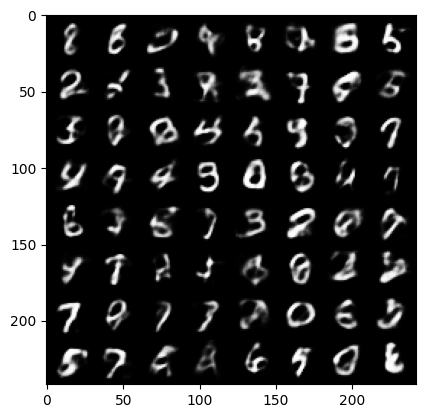

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    z = torch.randn(64, model.latent_dim).to(device)
    sample = model.decode(z).cpu()
    sample = sample.view(-1, 1, 28, 28)

grid_img = torchvision.utils.make_grid(sample, nrow=8)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()


## 2-2. 모델 구조   
### Conditional VAE   
VAE와 달리 latent vector와 같이 condition을 주고,   
condition을 이용해서 목표로 하는 image를 생성할 수 있도록
### 모델 구조 작성   
- 일반적으로 class 의 \_\_init\_\_ 함수부분에서 모듈들은 선언하고,
- 그 다음 forward 함수에 전체적인 흐름 작성   
- nn.sequential은 layer를 하나의 block으로 묶는 역할

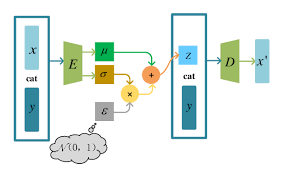   

출처: <https://www.researchgate.net/figure/The-conditional-variational-auto-encoder-CVAE-structure_fig2_376211055>   

In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=20, num_classes=10):
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # 인코더
        self.encoder = nn.Sequential(
            nn.Linear(28*28 + num_classes, 400),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # 디코더
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x, y):
        x = torch.cat([x.view(-1, 28*28), y], dim=1)
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        z = torch.cat([z, y], dim=1)
        return self.decoder(z)

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, y)
        return x_recon, mu, logvar


## one-hot vector 변환

In [ ]:
def one_hot(labels, num_classes = 10,):
    device = labels.device
    return torch.eye(num_classes, device = device)[labels]

## 3-2*. 옵티마이저 정의 및 학습
- batch 단위로 update 진행
- error와 gradients를 계산하고 업데이트!
- VAE와 동일한 loss function 사용
  - 입력만 x와 같이 y가 들어가는 차이점이 있음
- optimizer는 Adam 사용
- 학습 함수는 간단하여 별도 함수를 작성하지 않음



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConditionalVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        labels_onehot = one_hot(labels).to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = model(data, labels_onehot)
        loss = loss_function(x_recon, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset):.4f}')


Epoch 1, Loss: 162.8929
Epoch 2, Loss: 119.9558
Epoch 3, Loss: 112.7891
Epoch 4, Loss: 109.3711
Epoch 5, Loss: 107.2797
Epoch 6, Loss: 105.8114
Epoch 7, Loss: 104.7440
Epoch 8, Loss: 103.9709
Epoch 9, Loss: 103.2601
Epoch 10, Loss: 102.6975


## 4*. random 확률 분포를 이용한 image 생성
- latent vector와 목표로하는 숫자의 one-hot vector 부터 image (숫자) 생성



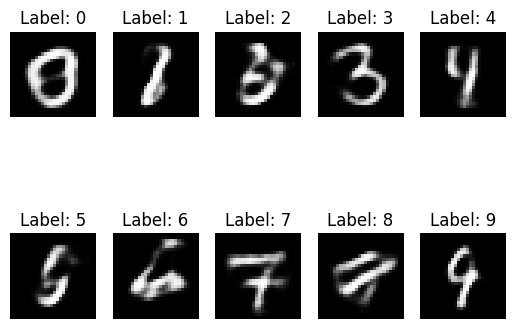

In [ ]:
model.eval()
with torch.no_grad():
    for i in range(10):
        z = torch.randn(1, model.latent_dim).to(device)
        label = torch.tensor([i])
        label_onehot = one_hot(label).to(device)
        sample = model.decode(z, label_onehot).cpu()
        sample = sample.view(28, 28)
        plt.subplot(2, 5, i+1)
        plt.imshow(sample, cmap='gray')
        plt.title(f'Label: {i}')
        plt.axis('off')
    plt.show()
